## Final Project Submission¶

Student name: Eduardo Osorio

Student pace: part time 

Scheduled project review date/time:

Instructor name: Yish Lim

Blog post URL:

## Log Transforming
- The first step were taking is log transforming the data to adjust the skewness

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

kcc = pd.read_csv('data_files/kc_cleaned.csv')

continuous = ['price', 'sqft_living', 'sqft_lot']
categoricals = ['bedrooms', 'floors', 'condition', 'waterfront', 'grade', 'zipcode', 'sale_month']

kcc_cont = kcc[continuous]

# log features
log_names = [f'{column}_log' for column in kcc_cont.columns]

kcc_log = np.log(kcc_cont)
kcc_log.columns = log_names


kcc_ohe = pd.get_dummies(kcc[categoricals], columns=['bedrooms', 'floors','condition', 'waterfront', 'zipcode', 'grade', 'sale_month'], drop_first=True)

preprocessed = pd.concat([kcc_log, kcc_ohe], axis=1)

## Stepwise function with backwards elimination
- This function will test the features and drop any features with p-values under .05

In [2]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, # Pvals over .05 are dropped
                       verbose=True):
 
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval)) #Adding pvals under the threshold

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval)) #drops pvals over thershold
        if not changed:
            break
    return included

## Train-Test Split
- Spliting the data with a train sample of 80%

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
X = preprocessed.drop('price_log', axis=1)
y = preprocessed['price_log']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
# Using a test size of 20%

## Feeding the train sample into the stepwise function

In [6]:
result = stepwise_selection(X_train, y_train, verbose = True)
print('resulting features:')
print(result)
#Feed x_train and Y_train into the stepwise function

C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  grade_7                        with p-value 0.0
Add  grade_6                        with p-value 0.0
Add  grade_8                        with p-value 0.0
Add  grade_5                        with p-value 0.0
Add  sqft_living_log                with p-value 0.0
Add  zipcode_98023                  with p-value 2.65628e-162
Add  zipcode_98004                  with p-value 2.91593e-162
Add  zipcode_98042                  with p-value 2.50415e-124
Add  zipcode_98092                  with p-value 1.49367e-113
Add  waterfront_1.0                 with p-value 4.09702e-110
Add  zipcode_98112                  with p-value 3.56427e-105
Add  zipcode_98003                  with p-value 3.02648e-99
Add  zipcode_98038                  with p-value 1.07296e-106
Add  zipcode_98030                  with p-value 1.42718e-102
Add  zipcode_98031                  with p-value 7.04371e-97
Add  zipcode_98058                  with p-value 4.75427e-97
Add  zipcode_98198                  with p-value 1.49642

C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Add  zipcode_98019                  with p-value 4.03334e-16
Drop zipcode_98055                  with p-value 0.528464
Add  zipcode_98146                  with p-value 8.56164e-18
Drop zipcode_98058                  with p-value 0.594966
Add  zipcode_98024                  with p-value 7.47091e-19
Drop zipcode_98178                  with p-value 0.346747
Add  zipcode_98070                  with p-value 3.8948e-13
Add  grade_13                       with p-value 1.37257e-09
Add  zipcode_98014                  with p-value 1.23638e-08
Add  zipcode_98038                  with p-value 2.83246e-07
Drop zipcode_98188                  with p-value 0.102068
Add  zipcode_98058                  with p-value 3.91749e-07
Drop zipcode_98198                  with p-value 0.810804
Add  zipcode_98055                  with p-value 9.31921e-08
Drop zipcode_98022                  with p-value 0.329653
Add  zipcode_98178                  with p-value 7.8222e-10
Drop zipcode_98168                  with p-v

## OLS

In [7]:
import statsmodels.api as sm
X_fin = X_train[result]
X_with_intercept = sm.add_constant(X_fin)
model = sm.OLS(y_train,X_with_intercept).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     1233.
Date:                Tue, 03 Nov 2020   Prob (F-statistic):               0.00
Time:                        10:46:38   Log-Likelihood:                 4165.7
No. Observations:               15372   AIC:                            -8151.
Df Residuals:                   15282   BIC:                            -7464.
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               8.7105      0.070    125.272      0.000       8.574       8.847
grade_7            -0.6709      0.024    -27.919      0.000      -0.718      -0.624
grade_6            -0.7501      0.025    -29.941      0.000      -0.799      -0.701
grade_8            -0.5582      0.024    -23.695      0.000      -0.604      -0.512
grade_5            -0.8221      0.029    -28.482      0.000      -0.879      -0.766
sqft_living_log     0.4676      0.006     75.164      0.000       0.455       0.480
zipcode_98023      -0.0663      0.011     -6.121      0.000      -0.088      -0.045
zipcode_98004       1.1039      0.014     80.625      0.000       1.077       1.131
zipcode_98092      -0.0347      0.013     -2.706      0.007      -0.060      -0.010
waterfront_1.0      0.6843      0.019     36.592      0.000       0.648       0.721
zipcode_98112       1.0345      0.014     71.681      0.000       1.006       1.063
zipcode_98003      -0.0320      0.014     -2.305      0.021      -0.059      -0.005
zipcode_98002      -0.0533      0.017     -3.228      0.001      -0.086      -0.021
grade_9            -0.4078      0.023    -17.424      0.000      -0.454      -0.362
condition_3         0.2688      0.038      7.017      0.000       0.194       0.344
zipcode_98032      -0.0770      0.020     -3.823      0.000      -0.116      -0.038
zipcode_98039       1.2962      0.030     42.652      0.000       1.237       1.356
zipcode_98115       0.7934      0.011     74.572      0.000       0.773       0.814
zipcode_98103       0.8244      0.011     75.747      0.000       0.803       0.846
zipcode_98117       0.7968      0.011     73.707      0.000       0.776       0.818
zipcode_98105       0.9340      0.016     60.108      0.000       0.904       0.964
zipcode_98119       0.9943      0.018     56.647      0.000       0.960       1.029
zipcode_98040       0.8606      0.015     59.121      0.000       0.832       0.889
zipcode_98199       0.8424      0.013     62.906      0.000       0.816       0.869
zipcode_98033       0.7479      0.012     63.506      0.000       0.725       0.771
zipcode_98107       0.8500      0.015     57.611      0.000       0.821       0.879
zipcode_98122       0.8099      0.014     57.407      0.000       0.782       0.838
zipcode_98116       0.7592      0.013     58.458      0.000       0.734       0.785
zipcode_98109       1.0142      0.022     46.235      0.000       0.971       1.057
zipcode_98102       0.9269      0.024     38.479      0.000       0.880       0.974
sqft_lot_log        0.0700      0.002     29.064      0.000       0.065       0.075
zipcode_98144       0.6792      0.013     51.047      0.000       0.653       0.705
zipcode_98006       0.6226      0.011     54.882      0.000       0.600       0.645
zipcode_98136       0.6886      0.015     47.464      0.000

## Recursive Feature Elimination
- This will automatically pic the most relevant features for our model

In [8]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 70)
selector = selector.fit(X_fin, y_train.values.ravel()) 
selector.support_ 

array([ True,  True,  True,  True,  True, False,  True, False,  True,
        True, False, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True, False, False,
       False, False,  True, False,  True, False, False, False])

In [9]:
selected_columns = X_fin.columns[selector.support_ ]
linreg.fit(X_fin[selected_columns],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
selected_columns

Index(['grade_7', 'grade_6', 'grade_8', 'grade_5', 'sqft_living_log',
       'zipcode_98004', 'waterfront_1.0', 'zipcode_98112', 'grade_9',
       'condition_3', 'zipcode_98039', 'zipcode_98115', 'zipcode_98103',
       'zipcode_98117', 'zipcode_98105', 'zipcode_98119', 'zipcode_98040',
       'zipcode_98199', 'zipcode_98033', 'zipcode_98107', 'zipcode_98122',
       'zipcode_98116', 'zipcode_98109', 'zipcode_98102', 'zipcode_98144',
       'zipcode_98006', 'zipcode_98136', 'zipcode_98052', 'zipcode_98008',
       'zipcode_98005', 'zipcode_98177', 'zipcode_98053', 'zipcode_98126',
       'zipcode_98029', 'zipcode_98125', 'zipcode_98034', 'zipcode_98075',
       'zipcode_98074', 'zipcode_98007', 'grade_10', 'grade_4',
       'zipcode_98118', 'zipcode_98027', 'condition_5', 'zipcode_98133',
       'condition_4', 'zipcode_98072', 'zipcode_98155', 'zipcode_98065',
       'zipcode_98011', 'zipcode_98028', 'grade_11', 'zipcode_98077',
       'zipcode_98059', 'zipcode_98106', 'zipcode_98108',

In [11]:
yhat = linreg.predict(X[selected_columns])
y_hat_train = linreg.predict(X_fin[selected_columns])
y_hat_test = linreg.predict(X_test[selected_columns])

## Checking R^2 and MSE
- Since we log transformed the data we need to un-log it to get an accurate squared error

In [12]:
SS_Residual = np.sum((y-yhat)**2)
SS_Total = np.sum((y-np.mean(y))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X[selected_columns].shape[1]-1)

In [13]:
r_squared

0.8629249647129205

In [14]:
adjusted_r_squared

0.8624237762840828

In [15]:
linreg.score(X_fin[selected_columns], y_train)

0.8655120207160176

In [18]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 0.03747158560568107
Test Mean Squarred Error: 0.040752354690299315


In [19]:
train_error_log = np.sqrt(mse_train)
test_error_log = np.sqrt(mse_test)
print(train_error_log)
print(test_error_log)

0.19357578775683976
0.20187212459945855


In [20]:
train_error = np.exp(train_error_log)
test_error = np.exp(test_error_log)
print('train error:',train_error)
print('test error:', test_error)

train error: 1.213581357675154
test error: 1.223691518062946


## Checking QQ Plot and Homoscedasticity

In [23]:
import scipy.stats as stats

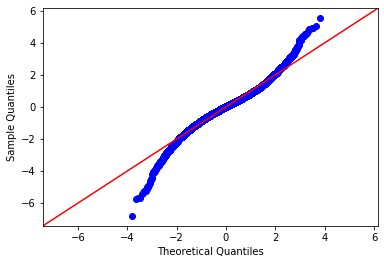

In [24]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

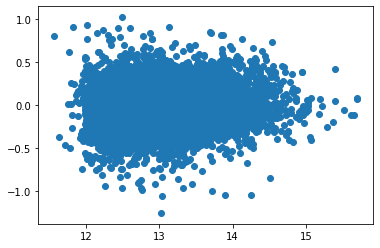

In [27]:
plt.scatter(y_hat_train, model.resid)
# plt.plot(y_hat_train(X_train[selected_columns])

## OLS
- Running OLS again to see how the model fits the test data

In [30]:
model = sm.OLS(y_test,X_test[selected_columns]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_log   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.559e+05
Date:                Tue, 03 Nov 2020   Prob (F-statistic):                        0.00
Time:                        10:52:19   Log-Likelihood:                         -43.305
No. Observations:                3844   AIC:                                      224.6
Df Residuals:                    3775   BIC:                                      656.2
Df Model:                          69                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
grade_7             0.0499      0.066      0.757      0.449      -0.079       0.179
grade_6             0.0915      0.068      1.350      0.177      -0.041       0.224
grade_8             0.0799      0.065      1.221      0.222      -0.048       0.208
grade_5             0.3342      0.075      4.430      0.000       0.186       0.482
sqft_living_log     0.7454      0.013     55.973      0.000       0.719       0.771
zipcode_98004       1.0838      0.033     33.211      0.000       1.020       1.148
waterfront_1.0      0.6982      0.041     17.183      0.000       0.619       0.778
zipcode_98112       1.0335      0.038     27.445      0.000       0.960       1.107
grade_9             0.1731      0.066      2.635      0.008       0.044       0.302
condition_3         6.8734      0.125     55.145      0.000       6.629       7.118
zipcode_98039       1.2520      0.102     12.228      0.000       1.051       1.453
zipcode_98115       0.7850      0.026     30.588      0.000       0.735       0.835
zipcode_98103       0.7761      0.025     30.854      0.000       0.727       0.825
zipcode_98117       0.7568      0.027     28.460      0.000       0.705       0.809
zipcode_98105       0.9165      0.038     24.261      0.000       0.842       0.991
zipcode_98119       0.9420      0.041     23.129      0.000       0.862       1.022
zipcode_98040       0.8414      0.036     23.437      0.000       0.771       0.912
zipcode_98199       0.8432      0.038     22.120      0.000       0.768       0.918
zipcode_98033       0.7286      0.030     23.951      0.000       0.669       0.788
zipcode_98107       0.8144      0.037     21.877      0.000       0.741       0.887
zipcode_98122       0.7715      0.036     21.653      0.000       0.702       0.841
zipcode_98116       0.7057      0.036     19.505      0.000       0.635       0.777
zipcode_98109       0.8998      0.057     15.671      0.000       0.787       1.012
zipcode_98102       0.9876      0.051     19.547      0.000       0.889       1.087
zipcode_98144       0.5898      0.032     18.539      0.000       0.527       0.652
zipcode_98006       0.6224      0.029     21.398      0.000       0.565       0.679
zipcode_98136       0.6520      0.037     17.532      0.000       0.579       0.725
zipcode_98052       0.5706      0.028     20.028      0.000       0.515       0.626
zipcode_98008       0.6119      0.034     17.942      0.000       0.545       0.679
zipcode_98005       0.6714      0.044     15.412      0.000       0.586       0.757
zipcode_98177       0.6167      0.036     17.221      0.000       0.546       0.687
zipcode_98053       0.5668      0.031     18.299      0.000       0.506       0.627
zipcode_98126       0.5128      0.038     13

- Looks like this model is not correctly fitting the data

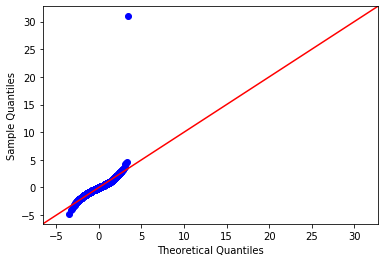

In [31]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

In [32]:
len(model.resid)

3844

In [33]:
X_train.shape

(15372, 110)